In [1]:
import numpy as np
import hvplot.xarray
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal

import xarray as xr
%matplotlib inline

da = xr.open_dataarray('one_meter_test.nc')

In [59]:
da
# get the values of the coordinates
da.coords['Alongshore'].values

array([  5.00000000e-01,   1.50000000e+00,   2.50000000e+00, ...,
         1.29750000e+03,   1.29850000e+03,   1.29950000e+03])

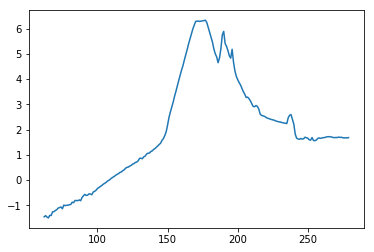

In [2]:
# extract a transect and plot
m = da[0,:,:]
m = m.fillna(0.).where(m>=-2)
plt.plot(np.flip(m[1000,:],0))


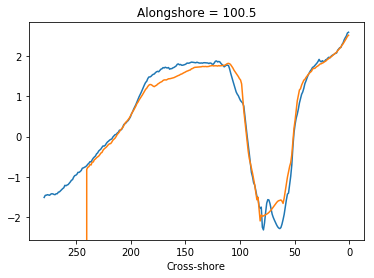

In [11]:
# plot using more native approach
da[0,100,:].plot(xincrease=False)
da[1,100,:].plot(xincrease=False)

<xarray.DataArray ()>
array(260)
Coordinates:
    Alongshore  float64 20.5 265


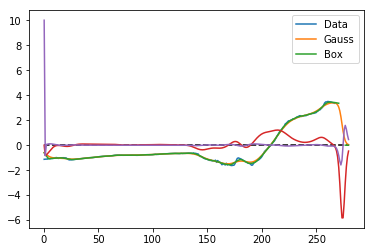

In [160]:
MWL = 0.
t = np.flip(da[0,20,:],0)
#x = np.flip(da.coords['Cross-shore'].values,0)
x = da.coords['Cross-shore'].values

idx = np.where(t<-100.)
t[idx]=np.NaN
# smooth
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

box_kernel = Box1DKernel(9)
gkn = 5
gkno2 = int(round(gkn/2.))
gauss_kernel = Gaussian1DKernel(gkn)
tsg = convolve(np.array(t), gauss_kernel)
# tsg[0:gkno2]=np.NaN
# tsg[-(gkno2+1):-1]=np.NaN
tsb = convolve(np.array(t), box_kernel)
dts = np.append([0.],np.diff(tsg))
ddts = np.append([1.],np.diff(dts))
dddts = np.append([1.],np.diff(ddts))

#idx = np.where((dts>0)) and np.where( np.abs(tsg)<=0.1) and np.where(x<150)
mlw = np.abs(tsg-MWL)<=0.1
xlimit = x<150.
pos_slope = dts>=5e-5
inflection = abs(ddts)<1e2
print(np.argmax(t),np.argmax(tsg))

kdx = np.logical_and( np.logical_and(mlw,pos_slope), xlimit)
fig, ax = plt.subplots()
plt.plot(x,np.zeros_like(x),'--k')
plt.plot(x,t,label='Data')
plt.plot(x,tsg,label='Gauss')
plt.plot(x,tsb,label='Box')
plt.plot(x,10*dts)
plt.plot(x,10*ddts)


plt.plot(x[kdx],t[kdx],'o')
ax.legend()

In [156]:
np.argmax(t)

<xarray.DataArray ()>
array(157)
Coordinates:
    Alongshore  float64 200.5

In [158]:
np.argmax(tsb)

4

In [135]:
# why does this return two values?
kdx = [0, 0, 0, 1, 0, 1, 0]
ii=np.where(kdx)
ii[0][0]

3

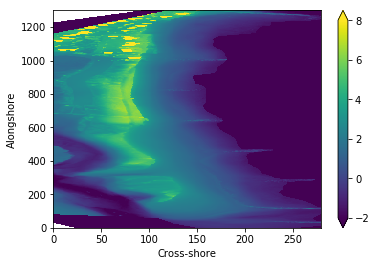

In [131]:
da.isel(map=12).plot(vmin=-2,vmax=8)

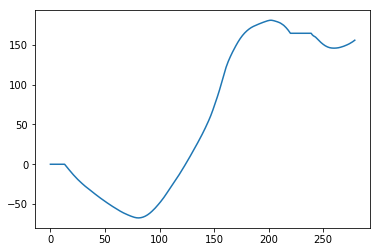

In [4]:
plt.plot(np.cumsum(np.flip(m[200,:],0)))

In [5]:
s = np.nansum(np.fliplr(m),1)

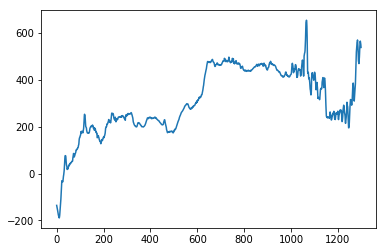

In [6]:
plt.plot(s)

In [7]:
idx = np.where(m[:,:]>0.)

In [8]:
np.shape(idx)

(2, 181240)